In [40]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import xlsxwriter
from xlsxwriter.utility import xl_rowcol_to_cell
import matplotlib.pyplot as plt
from matplotlib import style

from fuzzywuzzy import process
from collections import defaultdict

from survey_util import SURVEY_QUESTION_MAPPER
from survey_util import load_raw_survey_data

In [41]:
# Define paths and base directories

CHART_DIR = Path('../../data/survey/charts')
REPORT_DIR = Path('../../data/survey/report')

VIZ_DIR = Path('../../src/_data/viz/survey/phase_2')

raw_data = load_raw_survey_data()

base_respondents = len(raw_data)

columns = {
    '04_role',
    '05_overall_rating_arts_offer',
    '06_pupil_arts_entitlement',
    '07_additional_arts_funding',
    # '7a_arts_funding_sources',
    '09_competitions_showcases',
    '10_signposting_beyond_curriculum',
    '11_governors_creative_industries',
    '12_governor_dedicated_arts_remit',
    # '13_arts_facilities',
    '13c_unsupervised_access_facilities',
    '14_rating_extra_curricular_arts_enrichment_offering',
    # '15_offer_extracurricular_activity_select',
    '15b_supply_musical_instruments',
    # '15c_music_lessons_teachers_or_external',
    # '15d_orchestras_teachers_or_external',
    # '15e_choir_vocal_ensembles_internal_external',
    # '15f_dance_groups_internal_external',
    # '15g_drama_groups_internal_external',
    # '15h_dt_groups_internal_external',
    # '15i_digital_media_internal_external',
    # '15j_art_groups_internal_external',
    '16_arts_award',
    # '16a_teacher_arts_award_advisors_or_local_org',
    '17_arts_council',
    '18_external_orgs_arts_performances',
    '19_arts_trips',
    # '19a_arts_trips_funding',
    # '20_trips_undertaken_22_23',
    # '20b_theatre_trip_locations',
    # '20bi_theatre_trip_key_stages',
    # '20c_concert_trip_locations',
    # '20ci_concert_trip_key_stages',
    # '20d_cinema_trip_locations',
    # '20di_cinema_trip_key_stages',
    # '20e_gallery_trip_locations',
    # '20ei_gallery_trip_key_stages',
    # '20f_dance_trip_locations',
    # '20fi_dance_trip_key_stages',
    # '20g_museum_trip_locations',
    # '20gi_museum_trip_key_stages',
    # '20h_heritage_trip_locations',
    # '20hi_heritage_trip_key_stages',
    # '20i_gaming_trip_locations',
    # '20ii_gaming_trip_key_stages',
    # '20j_library_trip_locations',
    # '20ji_library_trip_key_stages',
    # '20k_community_trip_locations',
    # '20ki_community_trip_key_stages',
    '21_barriers_encouraging_recruiting_permissions_trips',
    '22_barriers_facilities_host_venues_trips',
    '23_national_programmes',
    '24_partnerships_external_orgs',
    '25_partnerships_local_schools',
    '26_community_based_arts_programmes',
    '28_partnerships_diversity_challenges',
    '29_pupil_practitioner_engagement_opportunities',
    '30_specialist_creative_career_advice',
    '31_data_pupil_progression_creative_education',
    # '31a_percentage_pupil_progression_creative_education',
    '32_supporting_teacher_cpd'
}

In [42]:
   
def break_down_by_school_type(data, question, output_file_path=VIZ_DIR):

    result = (
        data.groupby(['03_school_type', question])
        .size()
        .unstack(fill_value=0)
        .apply(lambda x: (x / x.sum()) * 100, axis=1)
        .round(0)
        .astype(int)
        .reset_index()
        .rename(columns={'03_school_type': 'School Type'})
    ).set_index('School Type')

    result['suffix'] = '%'

    result.to_csv(Path(output_file_path, '{}.csv'.format(question)), index=True)

    return result

In [43]:
def get_question_title(survey_questions, question):
    keys = [key for key, value in survey_questions.items() if value == question]
    if keys:
        return keys[0]
    return None

In [44]:
# Create a horizontal bar chart based on data for a given question

def create_chart(data, question, chart_dir=CHART_DIR, figsize=(6, 3)):

    responses = break_down_by_school_type(data, question)

    school_type = responses.index

    x = np.arange(len(school_type))
    x_labels = school_type

    width = 1/(len(responses.columns)) 
    multiplier = 0

    fig, ax = plt.subplots(figsize=figsize)
    plt.style.use('bmh')
    plt.rcParams.update({'font.size': 8})

    for attribute, measurement in responses.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        multiplier += 1

    ax.set_ylabel('Responses (%)')
    ax.set_title('{}'.format(get_question_title(SURVEY_QUESTION_MAPPER, question)), weight='bold', y=1.15, fontsize=9)
                
    ax.set_xticks(x + width * (len(responses) - 1) / 2)
    ax.set_xticklabels(x_labels)
    ax.legend(ncol=len(responses.columns), bbox_to_anchor=(1.1, 1.15), columnspacing=0.5)

    plt.tight_layout()

    # Save chart to file
    plt.savefig(chart_dir / '{}.png'.format(question), dpi=300, bbox_inches = "tight")

    # plt.show()


Write data to an Excel workbook

C:\Users\oi-user\AppData\Local\Temp\ipykernel_21336\3705781509.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


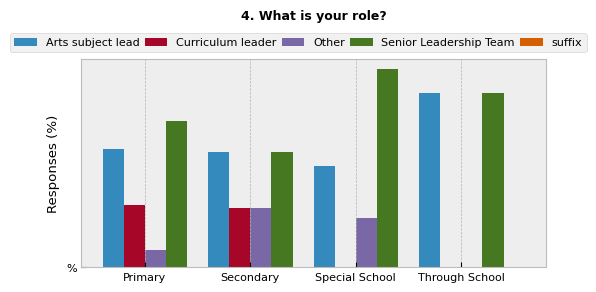

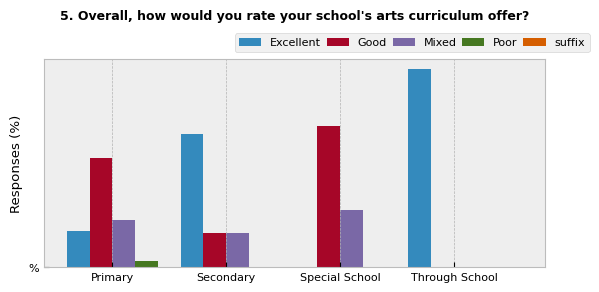

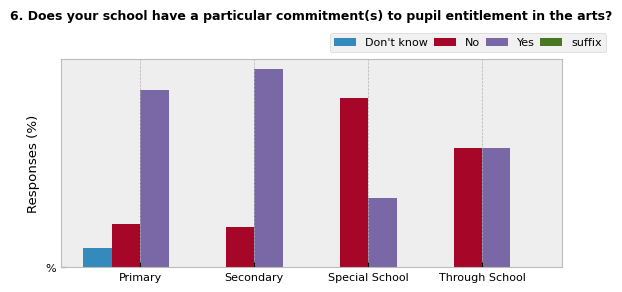

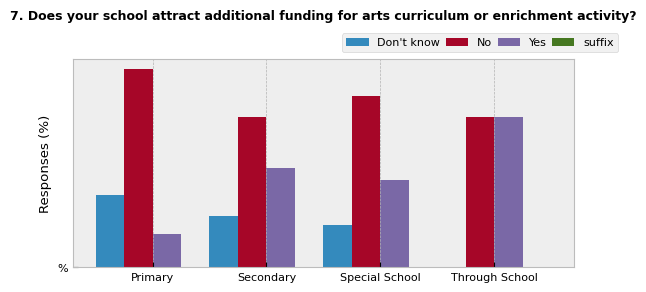

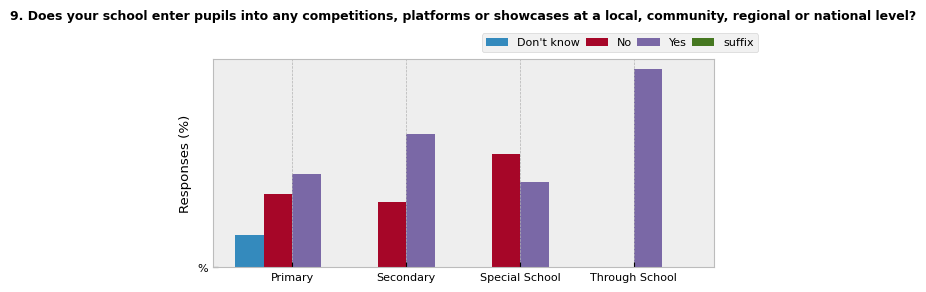

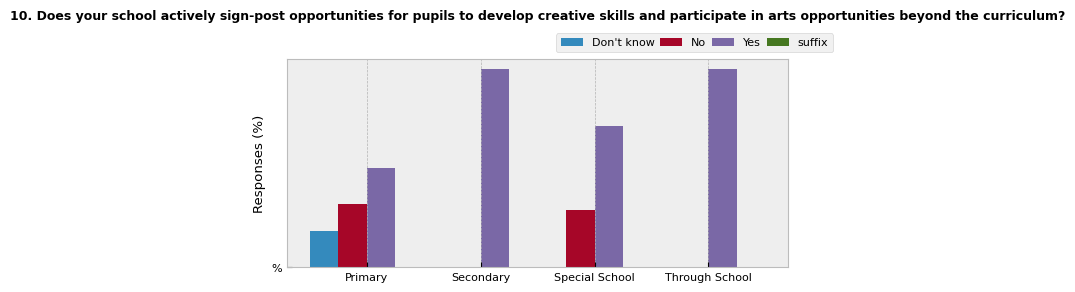

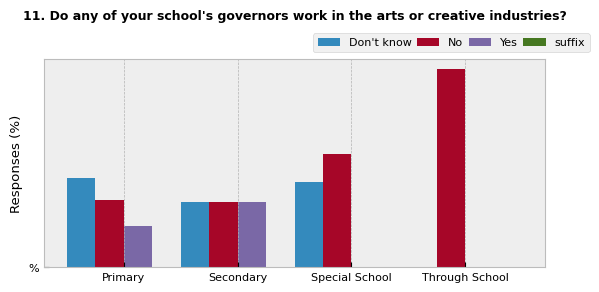

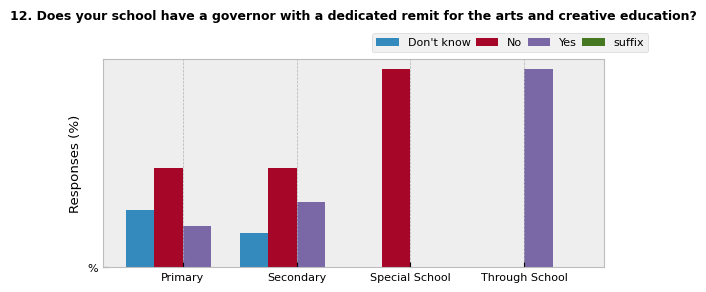

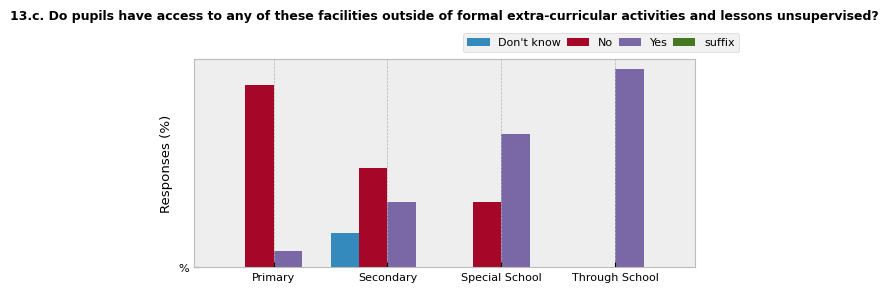

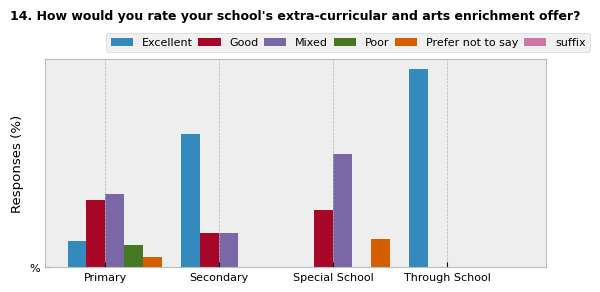

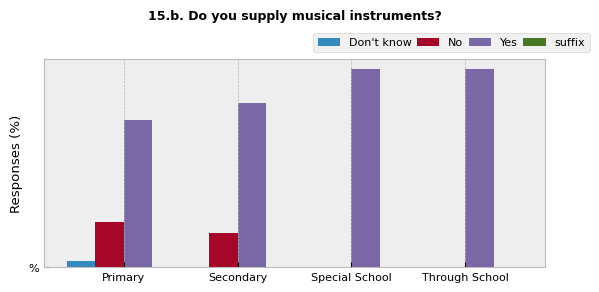

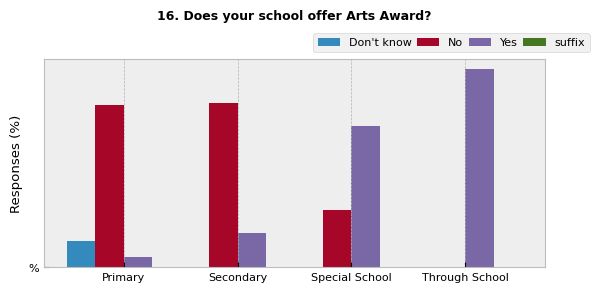

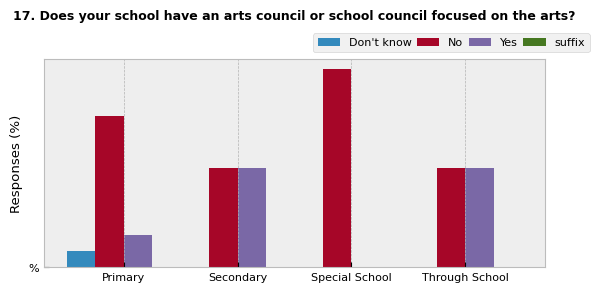

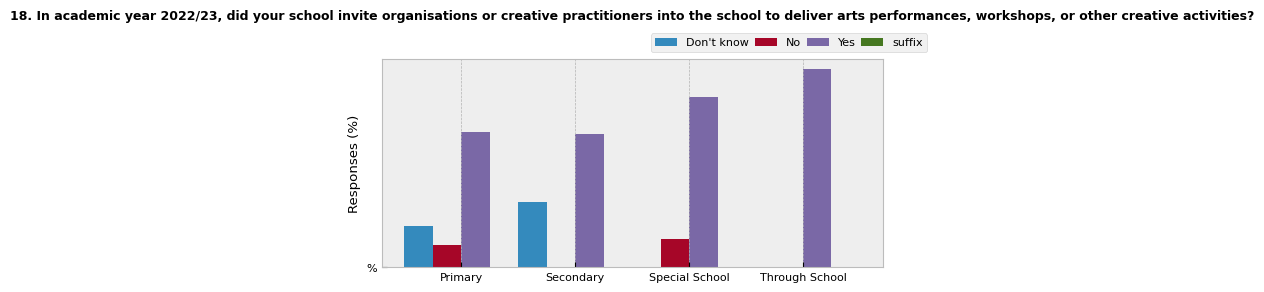

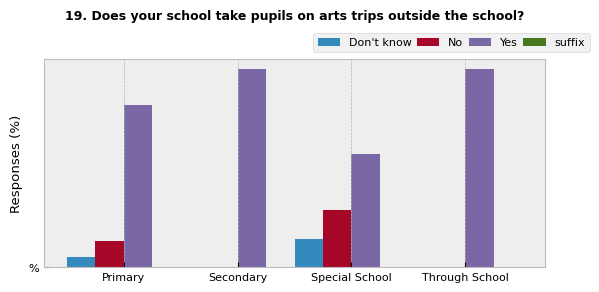

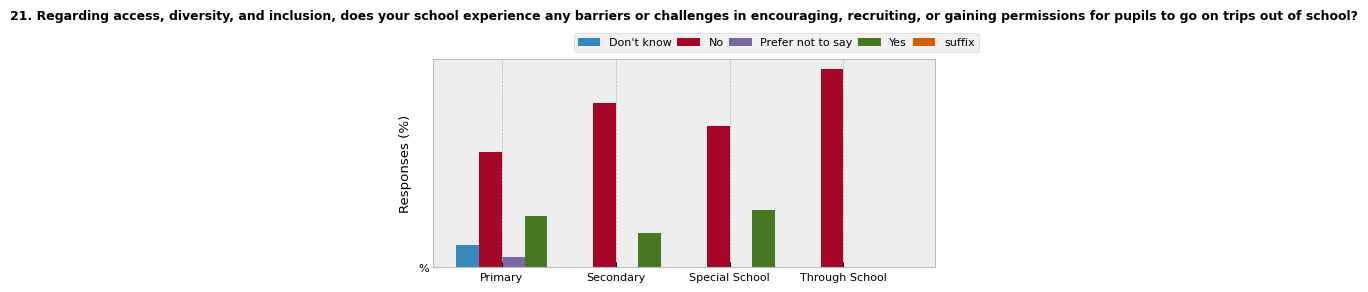

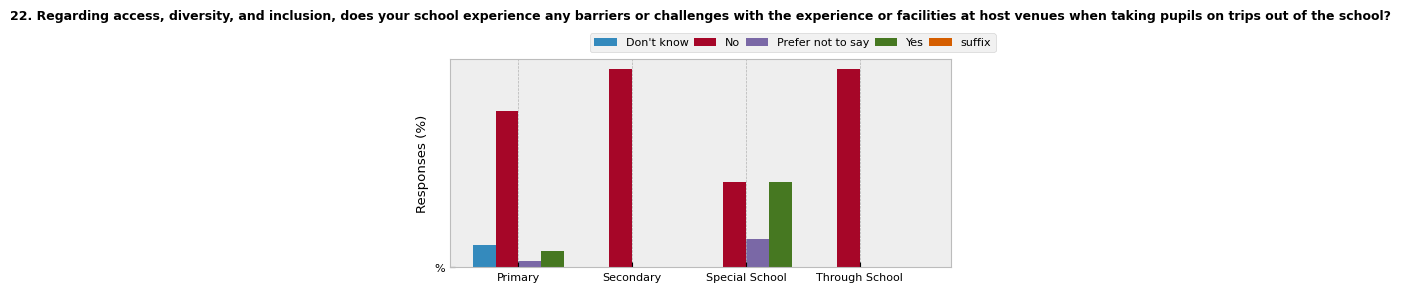

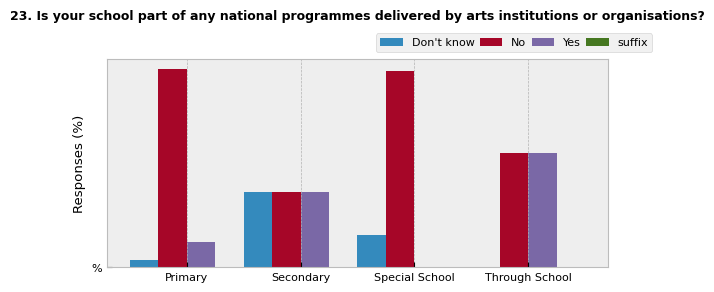

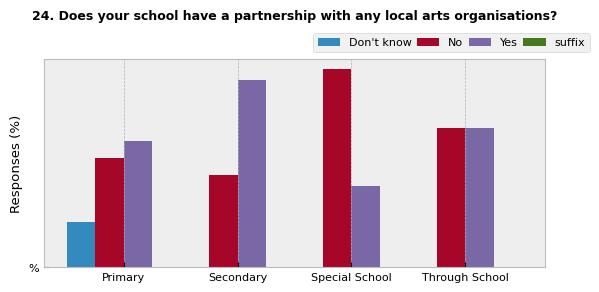

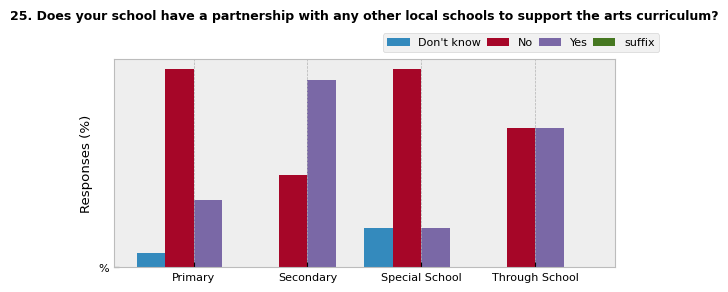

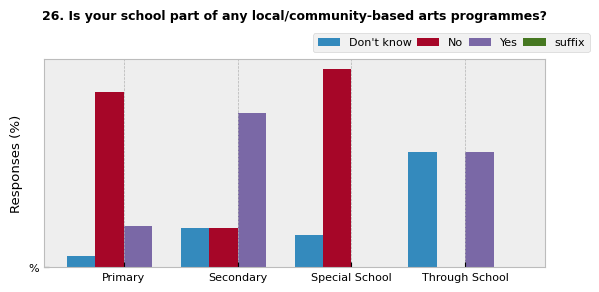

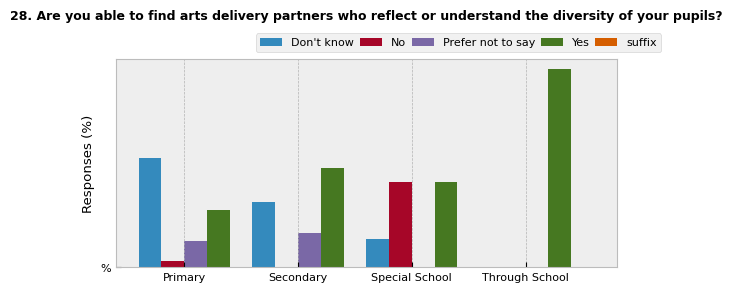

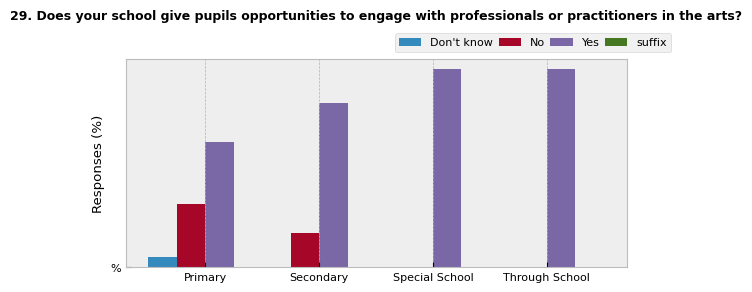

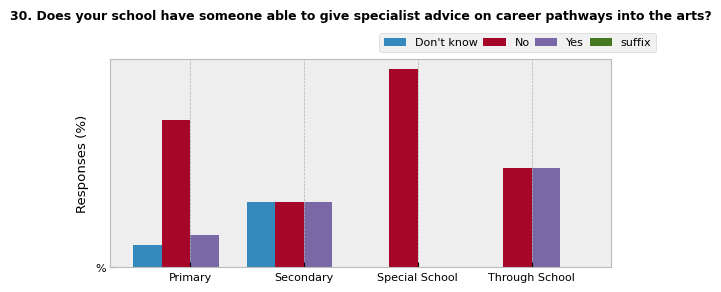

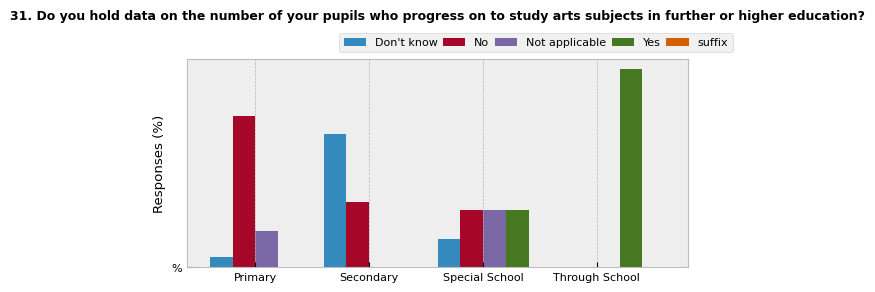

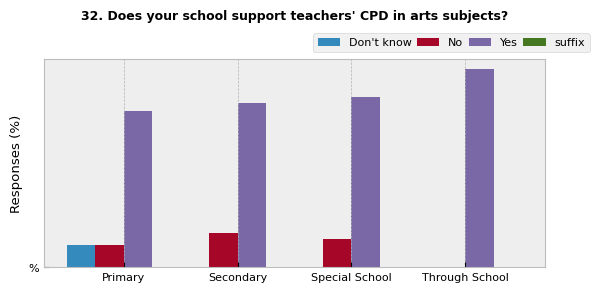

In [45]:

output_file = 'phase_2_analysis_report.xlsx'

def title_format(workbook):
    format = workbook.add_format({
        'bold': True, 
        "font_size": 16,
        })
    return format

def content_format(workbook):
    format = workbook.add_format({
        'align': 'left',
        "font_size": 12,
        })
    return format

with pd.ExcelWriter(os.path.join(REPORT_DIR, output_file), engine='xlsxwriter') as writer:
    workbook = writer.book
    worksheet = workbook.add_worksheet(f'Sheet1')

    adjusted_width = 150
    row_position = 9

    worksheet.write('B2', 'Phase 2 Survey Data Analysis', title_format(workbook))
    worksheet.write('B3', 
                    'This workbook contains the tables, charts and data analysis for the Creative Arts Education in Leeds Survey, 2024. It will be developed as the project progresses, and as more data sources become available for analysis.', 
                    content_format(workbook))

    for column in sorted(columns):
        responses = break_down_by_school_type(raw_data, column)

        worksheet.set_column(1, 5, 25)
        
        responses.to_excel(writer, sheet_name='Sheet1', startcol=1, startrow=row_position, index=True)

        responses_plot = create_chart(raw_data, column)

        chart_position = xl_rowcol_to_cell(row_position, 12)
        worksheet.insert_image(f'H{row_position}', Path(os.path.join(CHART_DIR, '{}.png'.format(column))))

        row_position += 20
